# **Data Preprocessing and Visualization**

### **DS 5110: Big Data Systems**

### **Spring 2022**

### **Group 1 - New York Times Articles Analysis**

### **Avni Malek (am7bf), Brittany Nguyen (bhn4bf), Cecily Wolfe (cew4pf)**

## **Getting the Data**

### **Set up Directory**

In [1]:
import os
os.getcwd()

'/home/cew4pf'

In [2]:
os.chdir('/project/ds5559/group1_nyt')

In [3]:
os.getcwd()

'/project/ds5559/group1_nyt'

In [4]:
from pyspark.sql import SparkSession

from pyspark.sql import functions as F

spark = SparkSession.builder \
        .appName("test_11") \
        .config("spark.executor.memory", '20g') \
        .getOrCreate()

## **Read in Data**

**Unzipped file with `unzip nyt-articles-2020.csv.zip` ([Source](https://sparkbyexamples.com/pyspark/pyspark-read-csv-file-into-dataframe/))**

**Add headers to columns with `read.option("header", True)`**

In [5]:
df = spark.read.option("header", True).csv('nyt-articles-2020.csv')

In [6]:
df.show(5)

+---------+------------------+----------+-------------------+--------------------+--------------------+--------------------+----------+--------------------+----------+--------------------+
| newsdesk|           section|subsection|           material|            headline|            abstract|            keywords|word_count|            pub_date|n_comments|            uniqueID|
+---------+------------------+----------+-------------------+--------------------+--------------------+--------------------+----------+--------------------+----------+--------------------+
|Editorial|           Opinion|      null|          Editorial|Protect Veterans ...|Congress could do...|['Veterans', 'For...|       680|2020-01-01 00:18:...|       186|nyt://article/69a...|
|    Games|Crosswords & Games|      null|               News|‘It’s Green and S...|Christina Iverson...|['Crossword Puzzl...|       931|2020-01-01 03:00:...|       257|nyt://article/9ed...|
|  Science|           Science|      null|              

## **Print Schema**

In [7]:
df.printSchema()

root
 |-- newsdesk: string (nullable = true)
 |-- section: string (nullable = true)
 |-- subsection: string (nullable = true)
 |-- material: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- word_count: string (nullable = true)
 |-- pub_date: string (nullable = true)
 |-- n_comments: string (nullable = true)
 |-- uniqueID: string (nullable = true)



### **Convert columns to different data type with `withColumn` and `df.col1.cast("dtype")`**
* https://sparkbyexamples.com/pyspark/pyspark-cast-column-type/

In [8]:
from pyspark.sql.functions import col

numeric_cols = ['word_count', 'n_comments']

for i in numeric_cols:
    df = df.withColumn(i, col(i).cast("double"))

In [9]:
from pyspark.sql.types import TimestampType

df = df.withColumn('pub_date', col('pub_date').cast(TimestampType()))

In [10]:
categorical_cols = [field for (field, dataType) in df.dtypes if dataType == "string"]

## **Check for and Replace Missing Values**

* check for missing values: from `data_preprocessing.ipydt` in `assingments/M4_3_data_preprocs_ungraded`)

* extract single values from a dataframe in pyspark: https://www.geeksforgeeks.org/pyspark-extracting-single-value-from-dataframe/

* drop multiple columns with `*`: https://sparkbyexamples.com/pyspark/pyspark-drop-column-from-dataframe/

* argument `subset` for subset of columns when replacing null values with `df.fillna`: https://sparkbyexamples.com/pyspark/pyspark-fillna-fill-replace-null-values/

In [11]:
from pyspark.sql import functions as F

In [12]:
# compute number of missing values for each col
df_miss = df.agg(*[(df.count() - F.count(c)).alias(c) for c in df.columns])

# cols to drop (if first value in df for that col is zero --> no missing values)
drop_cols = [c for c in df_miss.columns if df_miss.first()[c] == 0.0]

# drop cols without missing values
df_miss = df_miss.drop(*drop_cols)

df_miss.show()

+----------+--------+--------+----------+--------+----------+
|subsection|abstract|keywords|word_count|pub_date|n_comments|
+----------+--------+--------+----------+--------+----------+
|     11094|       3|       1|       649|     587|       556|
+----------+--------+--------+----------+--------+----------+



In [13]:
# numerical cols with missing values
numeric_miss_cols = [field for (field, dataType) in df.dtypes if dataType == 'double' and field in df_miss.columns]

# categorical cols with missing values
cat_miss_cols = [field for (field, dataType) in df.dtypes if dataType == 'string' and field in df_miss.columns]

In [14]:
# replace null values in numeric cols with 0
df = df.fillna(0, subset = numeric_miss_cols)

# replace null values in categorical cols with emptry string
df = df.fillna("", subset = cat_miss_cols)

### **Number of records**

In [15]:
df.count()

16787

### **Number of columns**

In [16]:
len(df.columns)

11

### **Statistical summary of numeric variables**

In [17]:
df.select(numeric_cols).describe().show()

+-------+------------------+-----------------+
|summary|        word_count|       n_comments|
+-------+------------------+-----------------+
|  count|             16787|            16787|
|   mean|1249.2137368201584|297.0196580687437|
| stddev| 966.9890478208722|  515.77408272921|
|    min|               0.0|              0.0|
|    max|           15619.0|           8987.0|
+-------+------------------+-----------------+



### **Statistical summary of categorial variables of interest**

* Calculating percentage of total count for groupBy using pyspark: https://stackoverflow.com/questions/52283751/calculating-percentage-of-total-count-for-groupby-using-pyspark

In [18]:
total = df.count()

newsdesk_sum =  df.groupBy('newsdesk').agg(F.count('newsdesk')).withColumnRenamed('count(newsdesk)','counts')

newsdesk_sum.withColumn('percent', newsdesk_sum.counts / total * 100).show()

+---------------+------+-------------------+
|       newsdesk|counts|            percent|
+---------------+------+-------------------+
|   Arts&Leisure|   266| 1.5845594805504257|
|     BookReview|   195| 1.1616131530350868|
|        At Home|     2|0.01191398105677012|
|          World|    20| 0.1191398105677012|
|       NewsDesk|    12|0.07148388634062072|
|       National|   715|  4.259248227795317|
|        Science|   750|  4.467742896288795|
|         TStyle|    78|0.46464526121403465|
|           Food|     3|0.01787097158515518|
|SpecialSections|    93| 0.5540001191398106|
|           Well|   615| 3.6635491749568114|
|          Video|     8|0.04765592422708048|
| Smarter Living|    12|0.07148388634062072|
|         AtHome|     6|0.03574194317031036|
|     T Magazine|     5| 0.0297849526419253|
|        Foreign|  1073|  6.391850836957169|
|         Sports|   552|  3.288258771668553|
|          Style|     4|0.02382796211354024|
| SundayBusiness|   122| 0.7267528444629773|
|         

In [19]:
section_sum =  df.groupBy('section').agg(F.count('section')).withColumnRenamed('count(section)','counts')

section_sum.withColumn('percent', section_sum.counts / total * 100).show()

+--------------+------+--------------------+
|       section|counts|             percent|
+--------------+------+--------------------+
|       At Home|     5|  0.0297849526419253|
|         World|  1183|   7.047119795079526|
|     Education|     7|0.041698933698695415|
|       Science|   354|  2.1087746470483113|
|          Food|   573|   3.413355572764639|
|          Well|   630|   3.752904032882588|
|         Video|     3| 0.01787097158515518|
|Smarter Living|     7|0.041698933698695415|
|    T Magazine|    83|    0.49443021385596|
| Times Insider|   115|  0.6850539107642819|
|        Sports|   569|  3.3895276106510988|
| Sunday Review|     7|0.041698933698695415|
|         Style|   400|   2.382796211354024|
|       Climate|   148|  0.8816345982009888|
|       Opinion|  2272|  13.534282480490855|
|    The Upshot|   338|    2.01346279859415|
|        Travel|   213|  1.2688389825460178|
|   Real Estate|   687|   4.092452493000536|
| Reader Center|    78| 0.46464526121403465|
|        H

In [20]:
subsection_sum =  df.groupBy('subsection').agg(F.count('subsection')).withColumnRenamed('count(subsection)','counts')

subsection_sum.withColumn('percent', subsection_sum.counts / total * 100).show()

+--------------------+------+-------------------+
|          subsection|counts|            percent|
+--------------------+------+-------------------+
|    Entrepreneurship|     5| 0.0297849526419253|
| Opinion | The World|     1|0.00595699052838506|
|              Tennis|    39|0.23232263060701733|
|    College Football|    27|0.16083874426639663|
|             Toddler|     1|0.00595699052838506|
|           Elections|    28|0.16679573479478166|
|Wine, Beer & Cock...|    90| 0.5361291475546555|
|International Bus...|     1|0.00595699052838506|
|                Golf|    20| 0.1191398105677012|
|              Europe|   350|  2.084946684934771|
|             Sailing|     1|0.00595699052838506|
|        Pro Football|   112| 0.6671829391791266|
|      New York Today|     1|0.00595699052838506|
|              Africa|    43|0.25615059272055757|
|      Space & Cosmos|     2|0.01191398105677012|
|       Sunday Review|   323| 1.9241079406683743|
|            Olympics|    30|0.17870971585155182|


## **Feature Engineering**

### **Create a New Column to Group Together Articles in Sections with Low Numbers**

* All articles in a section with 100 articles or less grouped in section "Other"
* Use later on to create a more balanced dataset

In [21]:
# create df with num of articles per section and sort by count in descending order
sections_df = df.groupby('section').count().sort('count', ascending = False)

# filter df to include only sections with more than 100 articles
top_sections = sections_df.filter(sections_df['count'] > 100)

# number of sections with more than 100 articles
num_top = top_sections.count()

top_sections.show(num_top)

+--------------------+-----+
|             section|count|
+--------------------+-----+
|                U.S.| 2364|
|             Opinion| 2272|
|               World| 1183|
|                Arts| 1094|
|            New York| 1055|
|        Business Day|  932|
|The Learning Network|  708|
|         Real Estate|  687|
|                Well|  630|
|                Food|  573|
|              Sports|  569|
|            Magazine|  471|
|  Crosswords & Games|  468|
|              Health|  425|
|               Style|  400|
|               Books|  371|
|             Science|  354|
|            Podcasts|  353|
|          The Upshot|  338|
|          Technology|  254|
|             Theater|  245|
|              Travel|  213|
|              Movies|  173|
|             Climate|  148|
|       Times Insider|  115|
+--------------------+-----+



In [22]:
df.select('section').distinct().count()

42

In [23]:
# list of distinct sections
distinct_sections = list(df.groupby('section').count().sort('count', ascending = False).toPandas()['section'])

# list of sections with more than 100 articles
top_secs = distinct_sections[:num_top]

In [24]:
from pyspark.sql.functions import *

# create a col that keeps section as is when in top_secs list; otherwise label 'Other' (i.e., articles in sections with <= 100 articles)
df = df.withColumn('new_section', when(df.section.isin(top_secs), df.section).otherwise('Other'))

In [25]:
# show new counts per section for all sections
df.groupby('new_section').count().sort('count', ascending = False).show(num_top + 1)

+--------------------+-----+
|         new_section|count|
+--------------------+-----+
|                U.S.| 2364|
|             Opinion| 2272|
|               World| 1183|
|                Arts| 1094|
|            New York| 1055|
|        Business Day|  932|
|The Learning Network|  708|
|         Real Estate|  687|
|                Well|  630|
|                Food|  573|
|              Sports|  569|
|            Magazine|  471|
|  Crosswords & Games|  468|
|              Health|  425|
|               Style|  400|
|               Other|  392|
|               Books|  371|
|             Science|  354|
|            Podcasts|  353|
|          The Upshot|  338|
|          Technology|  254|
|             Theater|  245|
|              Travel|  213|
|              Movies|  173|
|             Climate|  148|
|       Times Insider|  115|
+--------------------+-----+



In [26]:
# number of distinct sections when using "Other" section
df.select('new_section').distinct().count()

26

### **Add a new column for combined headline and abstract**

In [27]:
df = df.withColumn('combo', concat_ws(". ", df.headline, df.abstract))

df.select('combo').show(3, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|combo                                                                                                                                                                          |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Protect Veterans From Fraud. Congress could do much more to protect Americans who have served their country from predatory for-profit colleges.                                |
|‘It’s Green and Slimy’. Christina Iverson and Jeff Chen ring in the New Year.                                                                                                  |
|Meteor Showers in 2020 That Will Light Up Night Skies. All year long, Earth passes through streams of cosmic 

## **Create A Balanced Dataset**

In [28]:
import numpy as np

In [29]:
# load in functions that compute top k accuracy for classification and balance the data with random under/oversampling
from ds5110_proj_funcs import top_k_accuracy, balance_categories

In [30]:
# balance the data (see ds5100_proj_funcs.py for more information) --> each section sampled so ~ mean num of articles in each
balanced_data = balance_categories(df, "new_section")

## **Visualizations**

### **Bar Graph of Number of Articles by Newspaper Section with Original Sections (42 total)**

In [31]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

In [32]:
num_articles_per_section_og = df.groupBy("section").agg(F.count(df.section).alias("count")) \
                                .orderBy("count", ascending = False).toPandas()

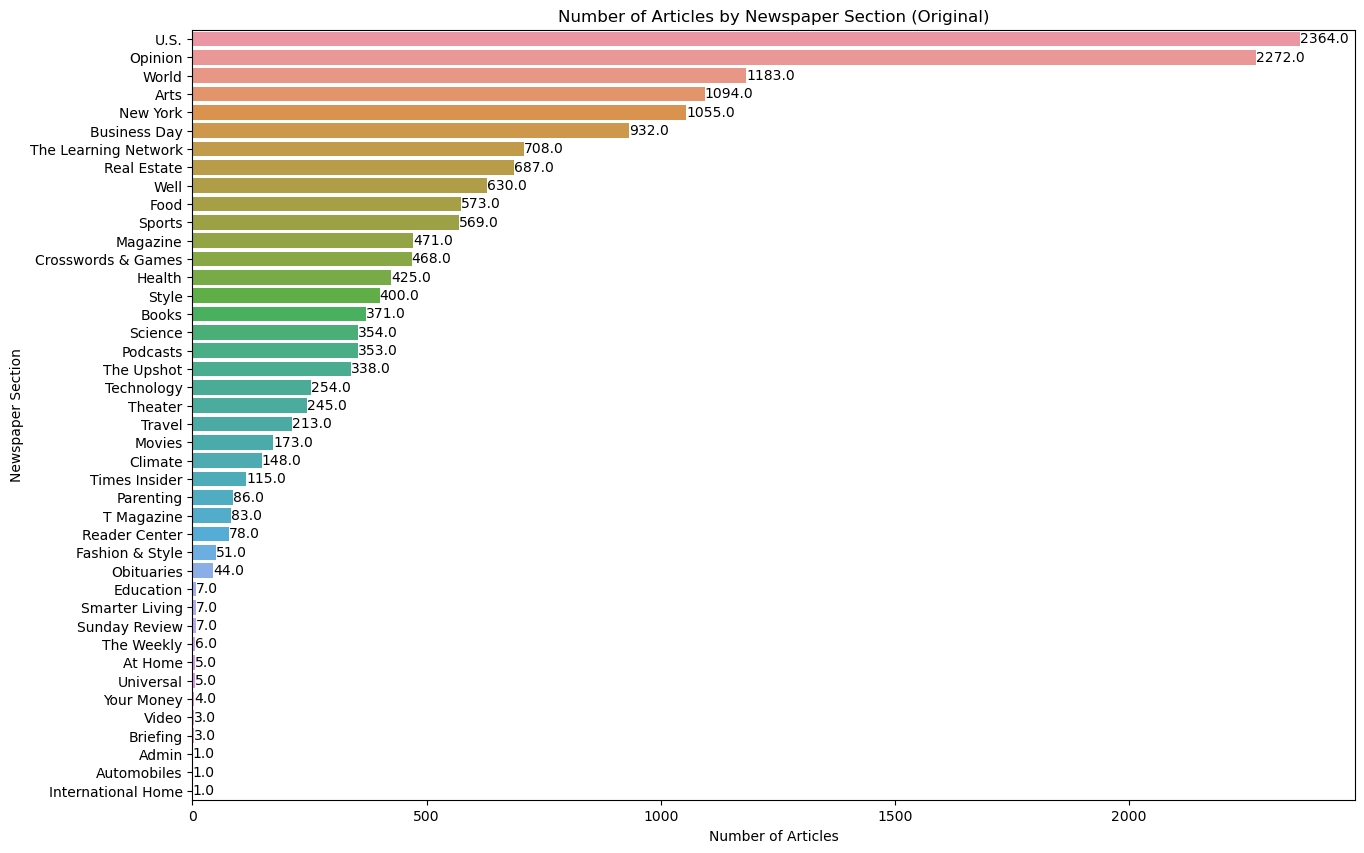

In [35]:
## code from Dr. Jonathan Kropko, University of Virginia School of Data Science; Surfing the Data Pipeline Ch. 11: Visualizations

# figure size
plt.figure(figsize=(15, 10))

# basic plot with axes labels and title
articles_per_sec = sns.barplot(x = 'count', y = 'section', data = num_articles_per_section_og)
plt.ylabel('Newspaper Section')
plt.xlabel('Number of Articles')
plt.title('Number of Articles by Newspaper Section (Original)')

# add counts to bars: for the patches (bars) in the plot
    # xcoor: get y-val + 0.5 * height (dim along y-axis) for label y-val --> offset upwards so that label centered
    # ycoor: get width for label x-val (dim along x-axis = count)
for rect in articles_per_sec.patches:
    xcoor = rect.get_y() + .5*rect.get_height()
    ycoor = rect.get_width()
    plt.text(ycoor, xcoor, str(ycoor), 
             horizontalalignment='left', 
             verticalalignment='center',
             fontsize=10)

plt.show()

plt.close()

### **Bar Graph of Number of Articles by Newspaper Section with New Sections (includes "Other"; 26 total)**

In [36]:
num_articles_per_section_new = df.groupBy("new_section").agg(F.count(df.new_section).alias("count")) \
                                 .orderBy("count", ascending = False).toPandas()

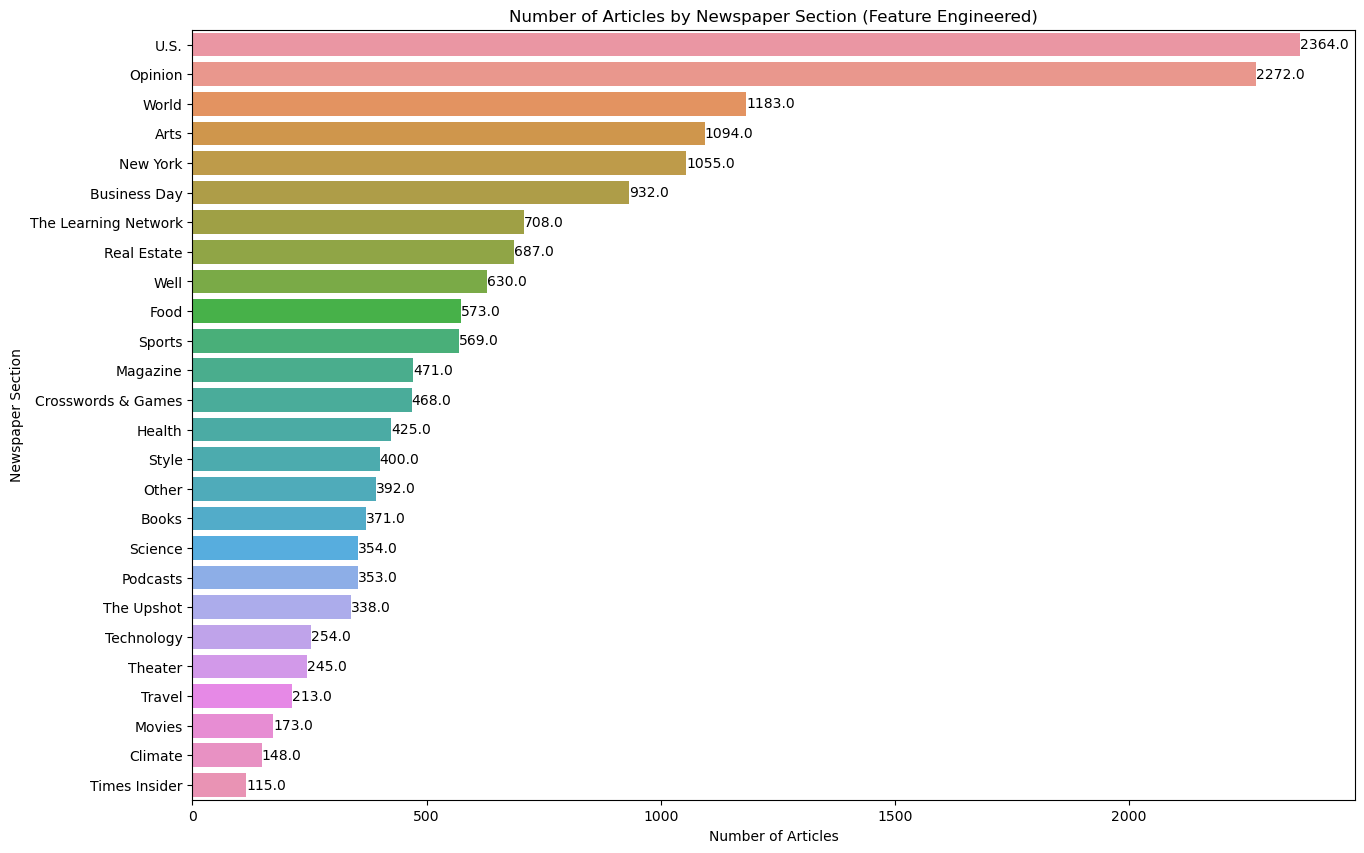

In [37]:
# figure size
plt.figure(figsize=(15, 10))

# basic plot with axes labels and title
articles_per_sec = sns.barplot(x = 'count', y = 'new_section', data = num_articles_per_section_new)
plt.ylabel('Newspaper Section')
plt.xlabel('Number of Articles')
plt.title('Number of Articles by Newspaper Section (Feature Engineered)')

# add counts to bars: for the patches (bars) in the plot
    # xcoor: get y-val + 0.5 * height (dim along y-axis) for label y-val --> offset upwards so that label centered
    # ycoor: get width for label x-val (dim along x-axis = count)
for rect in articles_per_sec.patches:
    xcoor = rect.get_y() + .5*rect.get_height()
    ycoor = rect.get_width()
    plt.text(ycoor, xcoor, str(ycoor), 
             horizontalalignment='left', 
             verticalalignment='center',
             fontsize=10)

plt.show()

plt.close()

### **Bar Graph of Number of Articles by Newspaper Section with New Sections (26 total) and Balanced Data**

In [38]:
num_articles_per_section_balanced = balanced_data.groupBy("new_section").agg(F.count(balanced_data.new_section).alias("count")) \
                                                  .orderBy("count", ascending = False).toPandas()

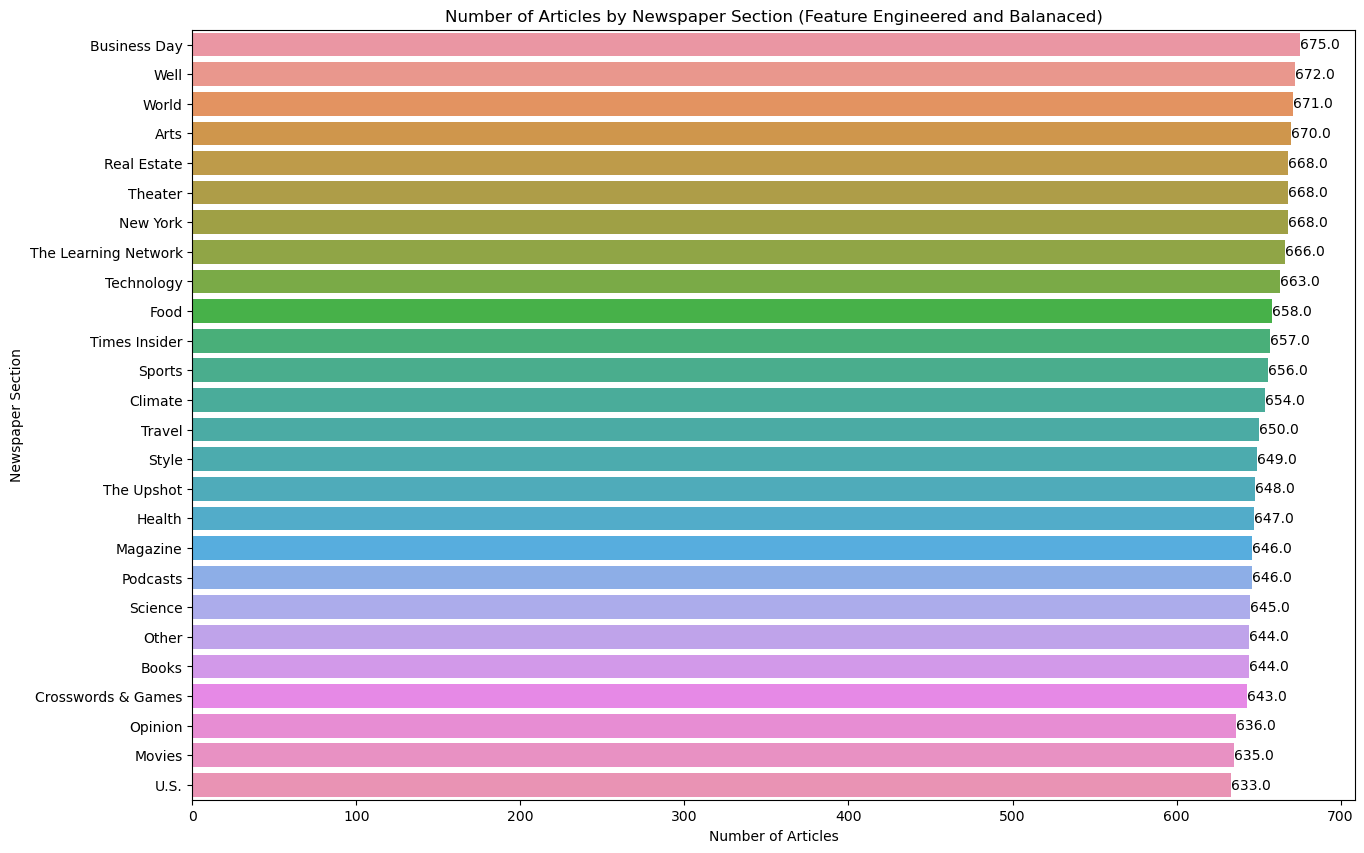

In [39]:
# figure size
plt.figure(figsize=(15, 10))

# basic plot with axes labels and title
articles_per_sec = sns.barplot(x = 'count', y = 'new_section', data = num_articles_per_section_balanced)
plt.ylabel('Newspaper Section')
plt.xlabel('Number of Articles')
plt.title('Number of Articles by Newspaper Section (Feature Engineered and Balanaced)')

# add counts to bars: for the patches (bars) in the plot
    # xcoor: get y-val + 0.5 * height (dim along y-axis) for label y-val --> offset upwards so that label centered
    # ycoor: get width for label x-val (dim along x-axis = count)
for rect in articles_per_sec.patches:
    xcoor = rect.get_y() + .5*rect.get_height()
    ycoor = rect.get_width()
    plt.text(ycoor, xcoor, str(ycoor), 
             horizontalalignment='left', 
             verticalalignment='center',
             fontsize=10)

plt.show()

plt.close()

## **Save Dataframe to a CSV**

In [38]:
# df.write.option("header", True).csv('preprocessed_data')

#### **Sources**

* Read a CSV file into Spark: https://sparkbyexamples.com/pyspark/pyspark-read-csv-file-into-dataframe/
* Convert columns to different data type with `withColumn` and `df.col1.cast("dtype")`: https://sparkbyexamples.com/pyspark/pyspark-cast-column-type/
* Check for missing values: from `data_preprocessing.ipydt` in `assingments/M4_3_data_preprocs_ungraded`)
* Extract single values from a dataframe in pyspark: https://www.geeksforgeeks.org/pyspark-extracting-single-value-from-dataframe/
* Drop multiple columns with `*`: https://sparkbyexamples.com/pyspark/pyspark-drop-column-from-dataframe/
* Argument `subset` for subset of columns when replacing null values with `df.fillna`: https://sparkbyexamples.com/pyspark/pyspark-fillna-fill-replace-null-values/
* Calculating percentage of total count for groupBy using pyspark: https://stackoverflow.com/questions/52283751/calculating-percentage-of-total-count-for-groupby-using-pyspark
* Spark Dataframe: How to add an index Column with `monotonically_increasing_id`: https://stackoverflow.com/questions/43406887/spark-dataframe-how-to-add-a-index-column-aka-distributed-data-index
* Classification and Regression in Spark: https://spark.apache.org/docs/latest/ml-classification-regression.html
* Multi-Class Text Classification with PySpark $\rightarrow$ for using `CountVectorizer`: https://towardsdatascience.com/multi-class-text-classification-with-pyspark-7d78d022ed35
* `CountVectorizer` documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html#pyspark.ml.feature.CountVectorizer.minDF
* PySpark: modify column values when another column value satisfies a condition with `when` and `otherwise` from `pyspark.sql.functions`: https://stackoverflow.com/questions/43988801/pyspark-modify-column-values-when-another-column-value-satisfies-a-condition
* Get value of a particular cell in PySpark Dataframe: https://www.geeksforgeeks.org/get-value-of-a-particular-cell-in-pyspark-dataframe/
* Using a fraction > 1.0 for up-sampling data: https://stackoverflow.com/questions/53273133/how-to-perform-up-sampling-using-sample-functionpy-spark
* Append data to an empty dataframe in PySpark: https://www.geeksforgeeks.org/append-data-to-an-empty-dataframe-in-pyspark/
* `pyspark.sql.functions.explode` documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.explode.html
* `pyspark.sql.functions.arrays_zip` documentation: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.arrays_zip.html
* Retrieve top n in each group of a DataFrame in pyspark: https://stackoverflow.com/questions/38397796/retrieve-top-n-in-each-group-of-a-dataframe-in-pyspark
* Introducing Window Functions in Spark SQL: https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html
* Convert PySpark DenseVector to array: https://stackoverflow.com/questions/58490770/convert-pyspark-densevector-to-array
* Aggregate function `collect_list`: https://sparkbyexamples.com/pyspark/pyspark-aggregate-functions/
* pyspark `collect_set` or `collect_list` with `groupby`: https://stackoverflow.com/questions/37580782/pyspark-collect-set-or-collect-list-with-groupby
* PySpark Join Types: https://sparkbyexamples.com/pyspark/pyspark-join-explained-with-examples/
* Removing duplicate columns after join in PySpark by specificying duplicate column in join function with argument `['col1']`: https://www.geeksforgeeks.org/removing-duplicate-columns-after-dataframe-join-in-pyspark/#:~:text=Removing%20duplicate%20columns%20after%20join,and%20then%20drop%20duplicate%20columns
* Count categories in another column after `groupby` with `.agg(countDistict('col1'))`: https://stackoverflow.com/questions/46421677/how-to-count-unique-id-after-groupby-in-pyspark
* Checking dataframe equality with `df1.subtract(df2)`: https://community.databricks.com/s/question/0D53f00001HKHZeCAP/comparing-two-dataframes
* Cross validation in pyspark: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html?highlight=crossvalidator
* Get (default) metric of `MulticlassMetrics` evaluator with `getMetricName()` method: https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/ml/evaluation/MulticlassClassificationEvaluator.html
* Increasing driver memory in Jupyter: https://stackoverflow.com/questions/51601478/setting-pyspark-executor-memory-and-executor-core-within-jupyter-notebook
* Getting the best parameter combination from cross validation using `zip` with `.avgMetrics` and `paramGrid`: https://community.databricks.com/s/question/0D53f00001HKHh5CAH/pyspark-how-to-get-best-params-in-grid-search
* Visualizations (bar graphs) code: https://jkropko.github.io/surfing-the-data-pipeline/ch11.html#distributional-graphs
* Nested list comprehensions: https://www.geeksforgeeks.org/nested-list-comprehensions-in-python/
* Remove a legend from a plot in `seaborn`: https://www.delftstack.com/howto/seaborn/remove-legend-seaborn-plot/
* Get the value in a particular row and column in Spark: https://www.geeksforgeeks.org/get-value-of-a-particular-cell-in-pyspark-dataframe/
* `15. ML Model Selection and Tuning.ipynb`
* `11. ML Pipelines.ipynb`
* `10. ML Feature Utilities.ipynb`
* `12. MLlib Regression.ipynb`
* `08. MLlib Statistics.ipynb`
* `09. MLlib Classification.ipynb`
* `07. Machine Learning with MLlib - Overview.ipynb`
* `05. SparkSession, Spark SQL and DataFrames.ipynb`
* `04. Running Spark on a Cluster.ipynb`
* `03. KeyValuePairs.ipynb`
* `02. RDDs.ipynb`
* `01. SparkGettingStarted.ipynb`